### Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import math
from collections import defaultdict
from pathlib import Path
import numpy as np
import torch
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('bmh')
from tqdm.notebook import tqdm
from importlib import reload
# import opendataval
# from utils import valuation

In [ ]:
!pip install opendataval

In [ ]:
import opendataval

In [ ]:
!mkdir figures

### Load CIFAR datasets

In [ ]:
# change path where data is stored
data_path = 'drive/MyDrive/data'
data_dir = Path(data_path)

# use training set for buyer data and test set for seller
cifar_orig_buyer = CIFAR10(root='data', train=True, download=True)
cifar_orig_seller = CIFAR10(root='data', train=False, download=True)
buyer_data = cifar_orig_buyer.data
buyer_targets = cifar_orig_buyer.targets
seller_data = cifar_orig_seller.data
seller_targets = cifar_orig_seller.targets

# load corrupted version of cifar test set
cifar_noise_path = data_dir / 'CIFAR-10-C'
gauss_data = np.load(cifar_noise_path / 'gaussian_noise.npy')
gauss_targets = np.array(seller_targets)
impulse_data = np.load(cifar_noise_path / 'impulse_noise.npy')
impulse_targets = np.array(seller_targets)
jpeg_data = np.load(cifar_noise_path / 'jpeg_compression.npy')
jpeg_targets = np.array(seller_targets)
blur_data = np.load(cifar_noise_path / 'motion_blur.npy')
blur_targets = np.array(seller_targets)
contrast_data = np.load(cifar_noise_path / 'contrast.npy')
contrast_targets = np.array(seller_targets)

print(seller_data.shape)
print(buyer_data.shape)
# print(gauss_data.shape)

# load distribution shifted version of cifar dataset
cifar_shift_path = data_dir / 'CIFAR-10.1/datasets'
shift_data = np.load(cifar_shift_path / 'cifar10.1_v4_data.npy')
shift_targets = np.load(cifar_shift_path / 'cifar10.1_v4_labels.npy')

100%|██████████| 170498071/170498071 [00:05<00:00, 30193956.92it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
(10000, 32, 32, 3)
(50000, 32, 32, 3)


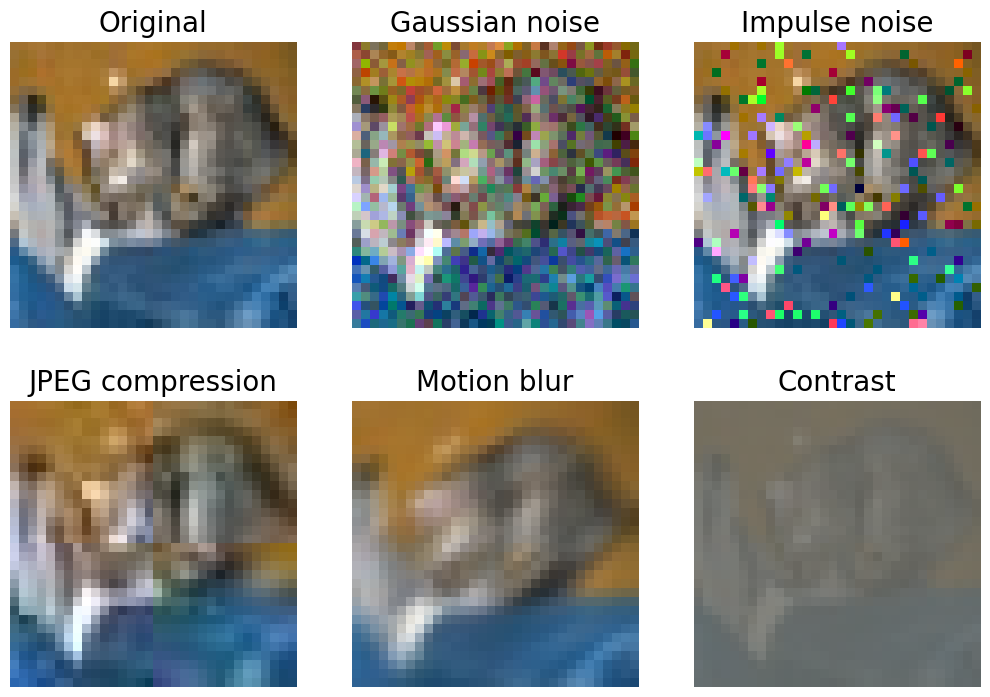

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
ax[0, 0].imshow(seller_data[0])
ax[0, 1].imshow(gauss_data[40000])
ax[0, 2].imshow(impulse_data[40000])
ax[1, 0].imshow(jpeg_data[40000])
ax[1, 1].imshow(blur_data[40000])
ax[1, 2].imshow(contrast_data[40000])
ax[0, 0].set_title('Original', fontsize=20, pad=8)
ax[0, 1].set_title('Gaussian noise', fontsize=20, pad=8)
ax[0, 2].set_title('Impulse noise', fontsize=20, pad=8)
ax[1, 0].set_title('JPEG compression', fontsize=20, pad=8)
ax[1, 1].set_title('Motion blur', fontsize=20, pad=8)
ax[1, 2].set_title('Contrast', fontsize=20, pad=8)
ax[0, 0].axis('off')
ax[0, 1].axis('off')
ax[0, 2].axis('off')
ax[1, 0].axis('off')
ax[1, 1].axis('off')
ax[1, 2].axis('off')

fig.tight_layout(h_pad=4, w_pad=4)
plt.savefig('figures/cifar-images.png', bbox_inches='tight')

### Embed image data through pre-trained model

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.eval();

make_loader = lambda x, bs=32: DataLoader(TensorDataset(torch.tensor(x / 255).float().moveaxis(-1, 1)), batch_size=bs)
embed_data = lambda x, mod: torch.cat([mod(x[0]).detach().cuda() for x in tqdm(make_loader(x))])

embed_buyer_data = embed_data(buyer_data, model)
embed_seller_data = embed_data(seller_data, model)
embed_shift_data = embed_data(shift_data, model)
embed_gauss_data = embed_data(gauss_data, model)
embed_impulse_data = embed_data(impulse_data, model)
embed_jpeg_data = embed_data(jpeg_data, model)
embed_blur_data = embed_data(blur_data, model)
embed_contrast_data = embed_data(contrast_data, model)

In [ ]:
import valuation

### Data valuations

In [ ]:
def get_value(pca, seller):
    rel = valuation.get_relevance(pca, seller.cpu())
    vol = valuation.get_volume(np.cov(pca.transform(seller.cpu()).T))
    return rel, max(vol, 1e-5)


# Change number of buyer components to project to calculate diversity and relevance
n_components=5

buyer_pca = PCA(n_components=n_components, svd_solver='randomized', whiten=False)
buyer_pca.fit(embed_buyer_data.cpu())

buyer_rel, buyer_div = get_value(buyer_pca, embed_buyer_data)
seller_rel, seller_div = get_value(buyer_pca, embed_seller_data)
shift_rel, shift_div = get_value(buyer_pca, embed_shift_data)


# CIFAR-C dataset has 5 noise levels for each corruption
gauss_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 10000, (noise_level + 1) * 10000)
    gauss_rel, gauss_div = get_value(buyer_pca, embed_gauss_data[s])
    gauss_valuations['relevance'].append(gauss_rel)
    gauss_valuations['diversity'].append(gauss_div)

impulse_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 10000, (noise_level + 1) * 10000)
    impulse_rel, impulse_div = get_value(buyer_pca, embed_impulse_data[s])
    impulse_valuations['relevance'].append(impulse_rel)
    impulse_valuations['diversity'].append(impulse_div)

jpeg_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 10000, (noise_level + 1) * 10000)
    jpeg_rel, jpeg_div = get_value(buyer_pca, embed_jpeg_data[s])
    jpeg_valuations['relevance'].append(jpeg_rel)
    jpeg_valuations['diversity'].append(jpeg_div)

blur_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 10000, (noise_level + 1) * 10000)
    blur_rel, blur_div = get_value(buyer_pca, embed_blur_data[s])
    blur_valuations['relevance'].append(blur_rel)
    blur_valuations['diversity'].append(blur_div)

contrast_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 10000, (noise_level + 1) * 10000)
    contrast_rel, contrast_div = get_value(buyer_pca, embed_contrast_data[s])
    contrast_valuations['relevance'].append(contrast_rel)
    contrast_valuations['diversity'].append(contrast_div)


shift_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 10000, (noise_level + 1) * 10000)
    shift_rel, shift_div = get_value(buyer_pca, embed_shift_data)
    shift_valuations['relevance'].append(shift_rel)
    shift_valuations['diversity'].append(shift_div)

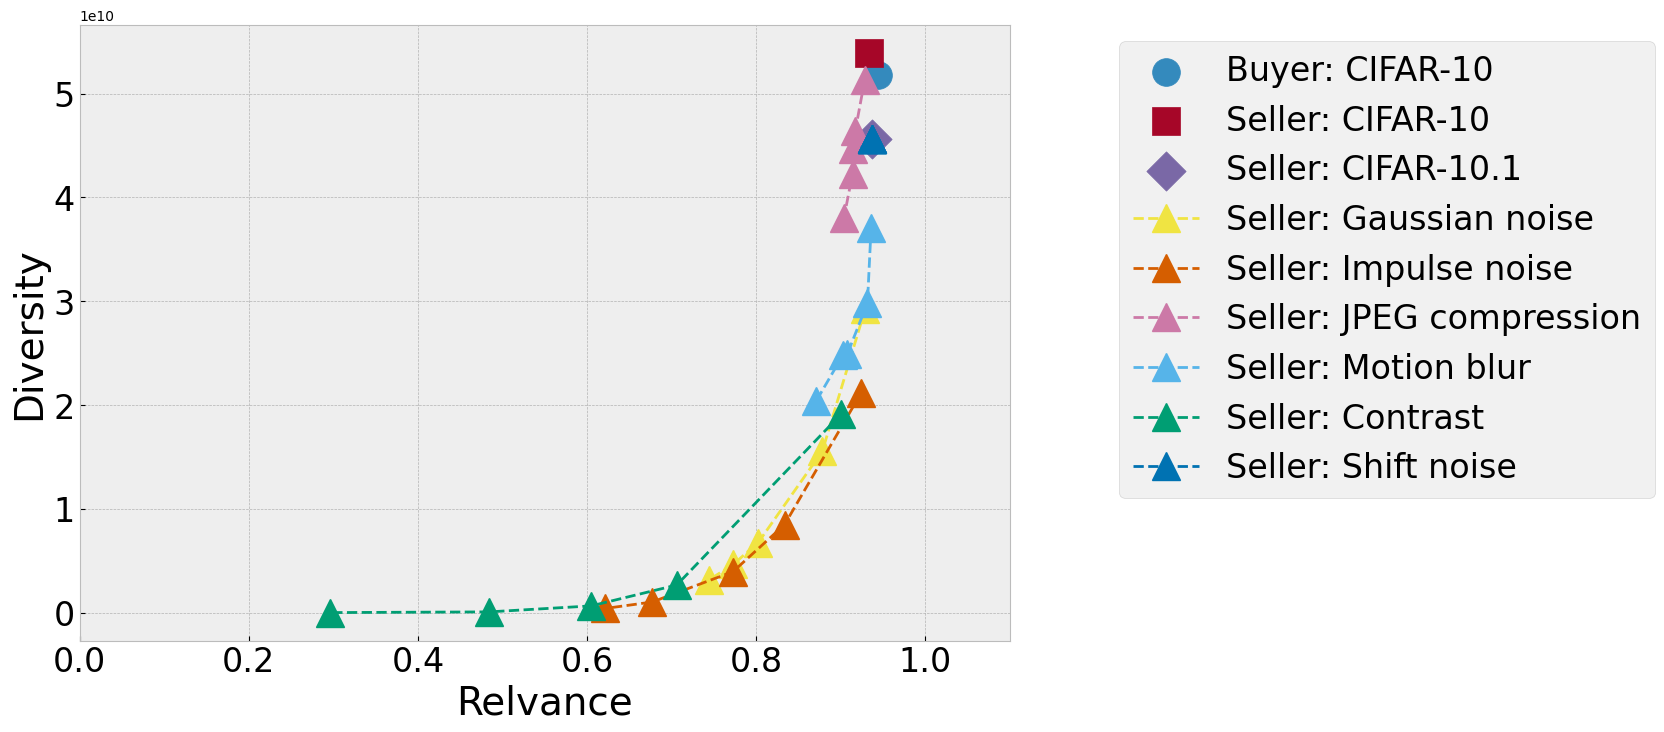

In [ ]:
s = 400
plt.figure(figsize=(12, 8))
plt.scatter(buyer_rel, buyer_div, s=s, marker='o', label='Buyer: CIFAR-10')
plt.scatter(seller_rel, seller_div, s=s, marker='s', label='Seller: CIFAR-10')
plt.scatter(shift_rel, shift_div, s=s, marker='D', label='Seller: CIFAR-10.1')
plt.plot(gauss_valuations['relevance'], gauss_valuations['diversity'], '^--', c='C8', markersize=20, label=f'Seller: Gaussian noise')
plt.plot(impulse_valuations['relevance'], impulse_valuations['diversity'], '^--', c='C4', markersize=20, label=f'Seller: Impulse noise')
plt.plot(jpeg_valuations['relevance'], jpeg_valuations['diversity'], '^--', c='C5', markersize=20, label=f'Seller: JPEG compression')
plt.plot(blur_valuations['relevance'], blur_valuations['diversity'], '^--', c='C6', markersize=20, label=f'Seller: Motion blur')
plt.plot(contrast_valuations['relevance'], contrast_valuations['diversity'], '^--', c='C7', markersize=20, label=f'Seller: Contrast')

plt.plot(shift_valuations['relevance'], shift_valuations['diversity'], '^--', c='C9', markersize=20, label=f'Seller: Shift noise')

plt.xlabel('Relvance', fontsize=28)
plt.ylabel('Diversity', fontsize=28)
plt.xlim(0, 1.1)
plt.title(label='',fontsize=20, pad=12)
plt.tick_params(labelsize=24)
plt.legend(fontsize=24, bbox_to_anchor=(1.1, 1))
plt.savefig('figures/cifar-noise.png', bbox_inches='tight')

### Experimentation with Different Transform Methods from torchvision.transforms library

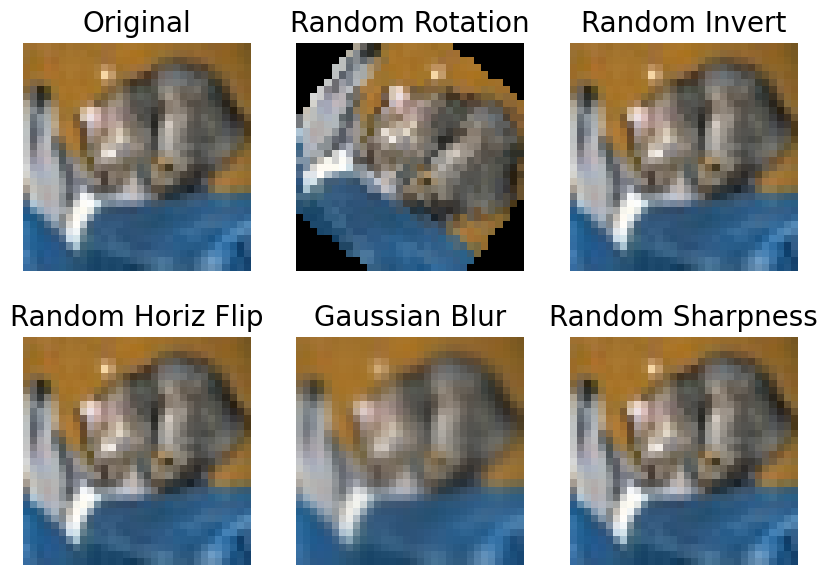

In [ ]:
import torchvision.transforms as transforms

random_rotate = transforms.RandomRotation(degrees = 60) #initialize transform modules
random_invert = transforms.RandomInvert(p = 0.5)
random_hflip = transforms.RandomHorizontalFlip(p = .5)
gaussian_blur = transforms.GaussianBlur(kernel_size = 5)
random_sharpness = transforms.RandomAdjustSharpness(sharpness_factor=2,p = .5)
tensor_transform = transforms.ToTensor()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))

ax[0,0].imshow(seller_data[0])
#permute method needed b/c [H,W,C] format needed but torch tensor transform methods map to [C,H,W]
ax[0, 1].imshow(random_rotate(tensor_transform(seller_data[0])).permute(1,2,0))
ax[0, 2].imshow(random_invert(tensor_transform(seller_data[0])).permute(1,2,0))
ax[1,0].imshow(random_hflip(tensor_transform(seller_data[0])).permute(1,2,0))
ax[1,1].imshow(gaussian_blur(tensor_transform(seller_data[0])).permute(1,2,0))
ax[1,2].imshow(random_sharpness(tensor_transform(seller_data[0])).permute(1,2,0))

ax[0, 0].set_title('Original', fontsize=20, pad=8)
ax[0, 1].set_title('Random Rotation', fontsize=20, pad=8)
ax[0, 2].set_title('Random Invert', fontsize=20, pad=8)
ax[1, 0].set_title('Random Horiz Flip', fontsize=20, pad=8)
ax[1, 1].set_title('Gaussian Blur', fontsize=20, pad=8)
ax[1, 2].set_title('Random Sharpness', fontsize=20, pad=8)

ax[0, 0].axis('off')
ax[0, 1].axis('off')
ax[0, 2].axis('off')
ax[1, 0].axis('off')
ax[1, 1].axis('off')
ax[1, 2].axis('off')

plt.savefig('figures/cifar-transform-images.png', bbox_inches='tight')

### Apply Transforms to Buyer Data

In [ ]:
#initialize datasets
rotate_data = np.zeros((50000,32,32,3))
invert_data = np.zeros((50000,32,32,3))
flip_data = np.zeros((50000,32,32,3))
gauss_blur_data = np.zeros((50000,32,32,3))
random_sharpness_data = np.zeros((50000,32,32,3))


for i in range(0,buyer_data.shape[0]):
    #multiply each output by 255 as tensor_transform maps [0,255] -> [0,1]
    rotate_data[i,:,:,:] = random_rotate(tensor_transform(buyer_data[i])).permute(1,2,0).numpy() * 255
    invert_data[i,:,:,:] = random_invert(tensor_transform(buyer_data[i])).permute(1,2,0).numpy() * 255
    flip_data[i,:,:,:] = random_hflip(tensor_transform(buyer_data[i])).permute(1,2,0).numpy() * 255
    gauss_blur_data[i,:,:,:] = gaussian_blur(tensor_transform(buyer_data[i])).permute(1,2,0).numpy() * 255
    random_sharpness_data[i,:,:,:] = random_sharpness(tensor_transform(buyer_data[i])).permute(1,2,0).numpy() * 255

### Embed Transformed Buyer Data

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.eval();

make_loader = lambda x, bs=32: DataLoader(TensorDataset(torch.tensor(x / 255).float().moveaxis(-1, 1)), batch_size=bs)
embed_data = lambda x, mod: torch.cat([mod(x[0]).detach().cuda() for x in tqdm(make_loader(x))])

embed_rotate_data = embed_data(rotate_data, model)
embed_invert_data = embed_data(invert_data, model)
embed_flip_data = embed_data(flip_data, model)
embed_gauss_blur_data = embed_data(gauss_blur_data, model)
embed_sharpness_data = embed_data(random_sharpness_data, model)

### Compute Data Valuations

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.eval();

make_loader = lambda x, bs=32: DataLoader(TensorDataset(torch.tensor(x / 255).float().moveaxis(-1, 1)), batch_size=bs)
embed_data = lambda x, mod: torch.cat([mod(x[0]).detach().cuda() for x in tqdm(make_loader(x))])

embed_buyer_data = embed_data(buyer_data,model)

In [ ]:
def get_value(pca, seller):
    rel = valuation.get_relevance(pca, seller)
    vol = valuation.get_volume(np.cov(pca.transform(seller).T))
    return rel, max(vol, 1e-5)


# Change number of buyer components to project to calculate diversity and relevance
n_components=5

buyer_pca = PCA(n_components=n_components, svd_solver='randomized', whiten=False)
buyer_pca.fit(embed_buyer_data.cpu())

buyer_rel, buyer_div = get_value(buyer_pca, embed_buyer_data.cpu())
# seller_rel, seller_div = get_value(buyer_pca, embed_seller_data)
# shift_rel, shift_div = get_value(buyer_pca, embed_shift_data)

# CIFAR-C dataset has 5 noise levels for each corruption
rotate_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 10000, (noise_level + 1) * 10000)
    rotate_rel, rotate_div = get_value(buyer_pca, embed_rotate_data[s].cpu())
    rotate_valuations['relevance'].append(rotate_rel)
    rotate_valuations['diversity'].append(rotate_div)

invert_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 10000, (noise_level + 1) * 10000)
    invert_rel, invert_div = get_value(buyer_pca, embed_invert_data[s].cpu())
    invert_valuations['relevance'].append(invert_rel)
    invert_valuations['diversity'].append(invert_div)

flip_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 10000, (noise_level + 1) * 10000)
    flip_rel, flip_div = get_value(buyer_pca, embed_flip_data[s].cpu())
    flip_valuations['relevance'].append(flip_rel)
    flip_valuations['diversity'].append(flip_div)

gauss_blur_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 10000, (noise_level + 1) * 10000)
    gauss_blur_rel, gauss_blur_div = get_value(buyer_pca, embed_gauss_blur_data[s].cpu())
    gauss_blur_valuations['relevance'].append(gauss_blur_rel)
    gauss_blur_valuations['diversity'].append(gauss_blur_div)

random_sharpness_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 10000, (noise_level + 1) * 10000)
    random_sharpness_rel, random_sharpness_div = get_value(buyer_pca, embed_sharpness_data[s].cpu())
    random_sharpness_valuations['relevance'].append(random_sharpness_rel)
    random_sharpness_valuations['diversity'].append(random_sharpness_div)

print(random_sharpness_valuations)
print(gauss_blur_valuations)
print(flip_valuations)
print(invert_valuations)
print(rotate_valuations)

### Plot Valuations

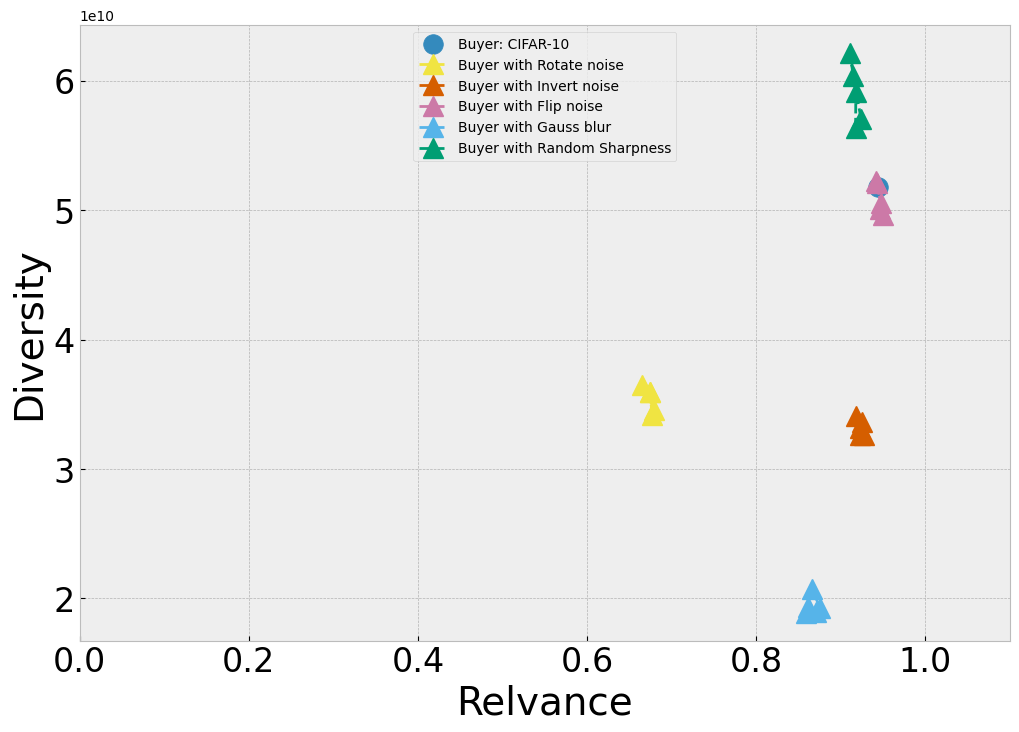

In [ ]:
s = 400
plt.figure(figsize=(12, 8))
plt.scatter(buyer_rel, buyer_div, s=200, marker='o', label='Buyer: CIFAR-10')
# plt.scatter(seller_rel, seller_div, s=200, marker='s', label='Seller: CIFAR-10')
# plt.scatter(shift_rel, shift_div, s=200, marker='D', label='Seller: CIFAR-10.1')
plt.plot(rotate_valuations['relevance'], rotate_valuations['diversity'], '^--', c='C8', markersize=15, label=f'Buyer with Rotate noise')
plt.plot(invert_valuations['relevance'], invert_valuations['diversity'], '^--', c='C4', markersize=15, label=f'Buyer with Invert noise')
plt.plot(flip_valuations['relevance'], flip_valuations['diversity'], '^--', c='C5', markersize=15, label=f'Buyer with Flip noise')
plt.plot(gauss_blur_valuations['relevance'], gauss_blur_valuations['diversity'], '^--', c='C6', markersize=15, label=f'Buyer with Gauss blur')
plt.plot(random_sharpness_valuations['relevance'], random_sharpness_valuations['diversity'], '^--', c='C7', markersize=15, label=f'Buyer with Random Sharpness')


plt.xlabel('Relvance', fontsize=28)
plt.ylabel('Diversity', fontsize=28)
plt.xlim(0, 1.1)
plt.title(label='',fontsize=20, pad=12)
plt.tick_params(labelsize=24)
plt.legend(loc = 'upper center')

### Apply Transformations to Seller Data

In [ ]:
#initialize datasets
rotate_seller_data = np.zeros((10000,32,32,3))
invert_seller_data = np.zeros((10000,32,32,3))
flip_seller_data = np.zeros((10000,32,32,3))
gauss_blur_seller_data = np.zeros((10000,32,32,3))
random_sharpness_seller_data = np.zeros((10000,32,32,3))

for i in range(0,seller_data.shape[0]):
    #multiply each output by 255 as tensor_transform maps [0,255] -> [0,1]
    rotate_seller_data[i,:,:,:] = random_rotate(tensor_transform(seller_data[i])).permute(1,2,0).numpy() * 255
    invert_seller_data[i,:,:,:] = random_invert(tensor_transform(seller_data[i])).permute(1,2,0).numpy() * 255
    flip_seller_data[i,:,:,:] = random_hflip(tensor_transform(seller_data[i])).permute(1,2,0).numpy() * 255
    gauss_blur_seller_data[i,:,:,:] = gaussian_blur(tensor_transform(seller_data[i])).permute(1,2,0).numpy() * 255
    random_sharpness_seller_data[i,:,:,:] = random_sharpness(tensor_transform(seller_data[i])).permute(1,2,0).numpy() * 255

### Embed Noisy Seller Data

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.eval();

make_loader = lambda x, bs=32: DataLoader(TensorDataset(torch.tensor(x / 255).float().moveaxis(-1, 1)), batch_size=bs)
embed_data = lambda x, mod: torch.cat([mod(x[0]).detach().cuda() for x in tqdm(make_loader(x))])

embed_rotate_seller_data = embed_data(rotate_seller_data, model)
embed_invert_seller_data = embed_data(invert_seller_data, model)
embed_flip_seller_data = embed_data(flip_seller_data, model)
embed_gauss_blur_seller_data = embed_data(gauss_blur_seller_data, model)
embed_sharpness_seller_data = embed_data(random_sharpness_seller_data, model)

### Compute Div, Rel Scores for Seller

In [ ]:
def get_value(pca, seller):
    rel = valuation.get_relevance(pca, seller)
    vol = valuation.get_volume(np.cov(pca.transform(seller).T))
    return rel, max(vol, 1e-5)

embed_buyer_data = embed_data(buyer_data,model)
# Change number of buyer components to project to calculate diversity and relevance
n_components=5

buyer_pca = PCA(n_components=n_components, svd_solver='randomized', whiten=False)
buyer_pca.fit(embed_buyer_data.cpu())

buyer_rel, buyer_div = get_value(buyer_pca, embed_buyer_data.cpu())
# seller_rel, seller_div = get_value(buyer_pca, embed_seller_data)
# shift_rel, shift_div = get_value(buyer_pca, embed_shift_data)

# CIFAR-C dataset has 5 noise levels for each corruption
#2000 selected as our hyperparameter here to remain in bounds
rotate_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 2000, (noise_level + 1) * 2000)
    rotate_rel, rotate_div = get_value(buyer_pca, embed_rotate_seller_data[s].cpu())
    rotate_valuations['relevance'].append(rotate_rel)
    rotate_valuations['diversity'].append(rotate_div)

invert_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 2000, (noise_level + 1) * 2000)
    invert_rel, invert_div = get_value(buyer_pca, embed_invert_seller_data[s].cpu())
    invert_valuations['relevance'].append(invert_rel)
    invert_valuations['diversity'].append(invert_div)

flip_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 2000, (noise_level + 1) * 2000)
    flip_rel, flip_div = get_value(buyer_pca, embed_flip_seller_data[s].cpu())
    flip_valuations['relevance'].append(flip_rel)
    flip_valuations['diversity'].append(flip_div)

gauss_blur_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 2000, (noise_level + 1) * 2000)
    gauss_blur_rel, gauss_blur_div = get_value(buyer_pca, embed_gauss_blur_seller_data[s].cpu())
    gauss_blur_valuations['relevance'].append(gauss_blur_rel)
    gauss_blur_valuations['diversity'].append(gauss_blur_div)

random_sharpness_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 2000, (noise_level + 1) * 2000)
    random_sharpness_rel, random_sharpness_div = get_value(buyer_pca, embed_sharpness_seller_data[s].cpu())
    random_sharpness_valuations['relevance'].append(random_sharpness_rel)
    random_sharpness_valuations['diversity'].append(random_sharpness_div)

print(random_sharpness_valuations)
print(gauss_blur_valuations)
print(flip_valuations)
print(invert_valuations)
print(rotate_valuations)

### Plot Scores

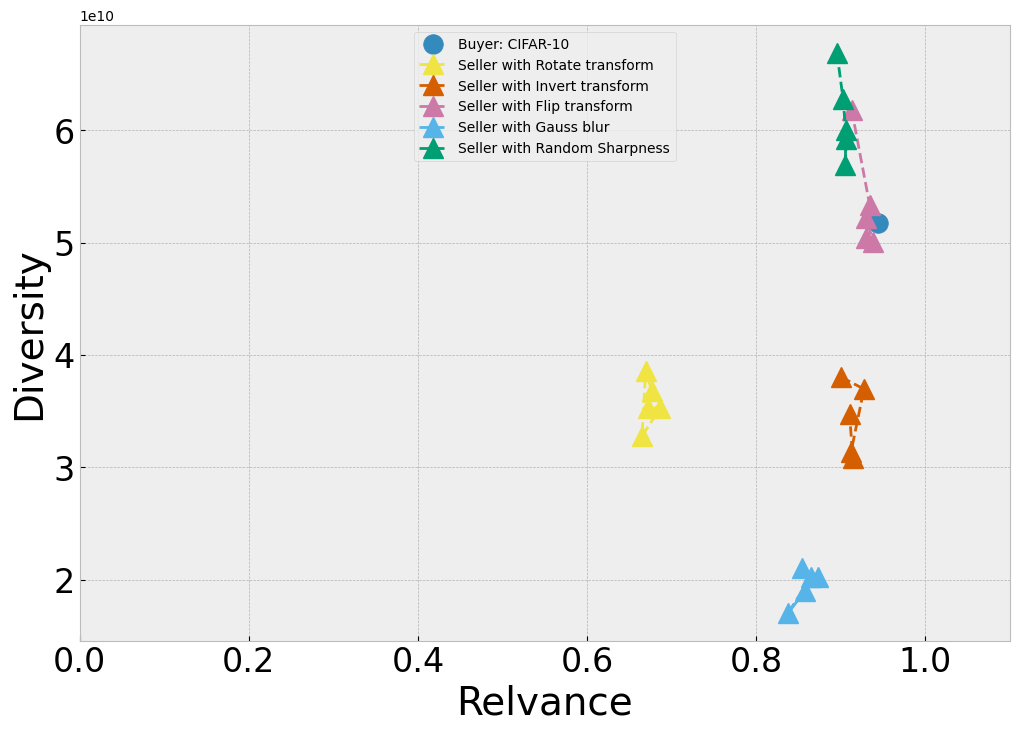

In [ ]:
s = 400
plt.figure(figsize=(12, 8))
plt.scatter(buyer_rel, buyer_div, s=200, marker='o', label='Buyer: CIFAR-10')
# plt.scatter(seller_rel, seller_div, s=200, marker='s', label='Seller: CIFAR-10')
# plt.scatter(shift_rel, shift_div, s=200, marker='D', label='Seller: CIFAR-10.1')
plt.plot(rotate_valuations['relevance'], rotate_valuations['diversity'], '^--', c='C8', markersize=15, label=f'Seller with Rotate transform')
plt.plot(invert_valuations['relevance'], invert_valuations['diversity'], '^--', c='C4', markersize=15, label=f'Seller with Invert transform')
plt.plot(flip_valuations['relevance'], flip_valuations['diversity'], '^--', c='C5', markersize=15, label=f'Seller with Flip transform')
plt.plot(gauss_blur_valuations['relevance'], gauss_blur_valuations['diversity'], '^--', c='C6', markersize=15, label=f'Seller with Gauss blur')
plt.plot(random_sharpness_valuations['relevance'], random_sharpness_valuations['diversity'], '^--', c='C7', markersize=15, label=f'Seller with Random Sharpness')


plt.xlabel('Relvance', fontsize=28)
plt.ylabel('Diversity', fontsize=28)
plt.xlim(0, 1.1)
plt.title(label='',fontsize=20, pad=12)
plt.tick_params(labelsize=24)
plt.legend(loc = 'upper center')

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=500, verbose=1)
classifier.fit(embed_buyer_data.cpu(), buyer_targets)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(embed_sharpness_seller_data.cpu())
sharp_accuracy = np.mean((seller_targets == predictions).astype(float)) * 100.
print(f"Sharp Accuracy = {sharp_accuracy:.3f}")

predictions = classifier.predict(embed_gauss_blur_seller_data.cpu())
gauss_accuracy = np.mean((seller_targets == predictions).astype(float)) * 100.
print(f"Gauss Accuracy = {gauss_accuracy:.3f}")

predictions = classifier.predict(embed_rotate_seller_data.cpu())
rotate_accuracy = np.mean((seller_targets == predictions).astype(float)) * 100.
print(f"Rotate Accuracy = {rotate_accuracy:.3f}")

predictions = classifier.predict(embed_invert_seller_data.cpu())
invert_accuracy = np.mean((seller_targets == predictions).astype(float)) * 100.
print(f"Invert Accuracy = {invert_accuracy:.3f}")

predictions = classifier.predict(embed_flip_seller_data.cpu())
flip_accuracy = np.mean((seller_targets == predictions).astype(float)) * 100.
print(f"Flip Accuracy = {flip_accuracy:.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sharp Accuracy = 60.990
Gauss Accuracy = 44.470
Rotate Accuracy = 31.260
Invert Accuracy = 50.070
Flip Accuracy = 61.630


See how transforms affect model performance
Use digits.py functions on CIFAR dataset for noise
Clip embedding experimentation in mnist-compare-diversity-clip-embeddings.ipynb will want GPU
Train model to predict on the most diverse/relevant dataset
Digits.py has CNN model to use
Instead of get_valuation use get_value
Feed in original data to see how model performance is predicted
Plot test accuracies for each
Experiment with Apple mps

### Test clip embeddings

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
import clip
model, preprocess = clip.load("ViT-B/16", device='cuda')

100%|███████████████████████████████████████| 335M/335M [00:03<00:00, 89.6MiB/s]


In [ ]:
import importlib
import data
importlib.reload(data)

<module 'data' from '/content/data.py'>

In [ ]:
from torchvision.transforms import Compose, ToPILImage

model.eval()

make_loader = lambda x, batch_size=16: torch.utils.data.DataLoader(
    data.simple_DS(x, transforms=Compose([ToPILImage(), preprocess])),
    batch_size=batch_size,
)
data_dict = dict(
    embed_buyer_data=buyer_data.astype(np.uint8),
    rot_seller_data=rotate_seller_data.astype(np.uint8),
    inv_seller_data=invert_seller_data.astype(np.uint8),
    flip_data=flip_seller_data.astype(np.uint8),
    gauss_blur=gauss_blur_seller_data.astype(np.uint8),
    sharp_data=random_sharpness_seller_data.astype(np.uint8),
)
num_samples = 10000
features_dict = {
    k: torch.cat([model.encode_image(x.cuda()).detach().cpu() for x in tqdm(make_loader(v[:None if k == 'mnist_seller' else num_samples]))])
    for k, v in data_dict.items()
}

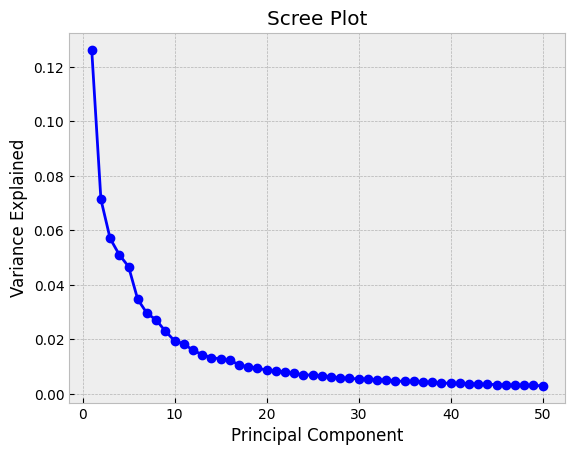

defaultdict(<class 'list'>, {'relevance': [0.5783256249645263, 0.5783256249645263, 0.5783256249645263, 0.5783256249645263, 0.5783256249645263], 'diversity': [0.37990031385864265, 0.37990031385864265, 0.37990031385864265, 0.37990031385864265, 0.37990031385864265]})
defaultdict(<class 'list'>, {'relevance': [0.8872038947685449, 0.9122037441254972, 0.8801629976498141, 0.8884886287203699, 0.8877495215646373], 'diversity': [0.07988463275607885, 0.04486582425548927, 0.09818256583306505, 0.08508599093871272, 0.08410033468432296]})
defaultdict(<class 'list'>, {'relevance': [0.9515268392640651, 0.960245942059959, 0.9661413914809913, 0.970127566391506, 0.9603744746601441], 'diversity': [0.03775194449523705, 0.029857677835989027, 0.025790839557476155, 0.02422549240127979, 0.033794401048772085]})
defaultdict(<class 'list'>, {'relevance': [0.7012664234222676, 0.6854994695780281, 0.6928325213493371, 0.7020417797975698, 0.6942033081188175], 'diversity': [0.24408355340216434, 0.2676769133019828, 0.230

In [ ]:
# def get_value(pca, seller):
#     rel = valuation.get_relevance(pca, seller)
#     vol = valuation.get_volume(np.cov(pca.transform(seller).T))
#     return rel, max(vol, 1e-5)

# Change number of buyer components to project to calculate diversity and relevance
n_components=50

buyer_pca = PCA(n_components=n_components, svd_solver='randomized', whiten=False)
buyer_pca.fit(features_dict['embed_buyer_data'])

#make scree plot
PC_values = np.arange(buyer_pca.n_components_) + 1
plt.plot(PC_values, buyer_pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

buyer_rel, buyer_div = valuation.get_value(features_dict['embed_buyer_data'], features_dict['embed_buyer_data'],pca=None)['relevance'],valuation.get_value(features_dict['embed_buyer_data'], features_dict['embed_buyer_data'],pca=None)['diversity']
# seller_rel, seller_div = get_value(features_dict['embed_buyer_data'], embed_seller_data)
# shift_rel, shift_div = get_value(features_dict['embed_buyer_data'], embed_shift_data)

# CIFAR-C dataset has 5 noise levels for each corruption
#2000 selected as our hyperparameter here to remain in bounds
rotate_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 2000, (noise_level + 1) * 2000)
    rotate_rel, rotate_div = valuation.get_value(features_dict['embed_buyer_data'],features_dict['rot_seller_data'],pca=None)['relevance'],valuation.get_value(features_dict['embed_buyer_data'],features_dict['rot_seller_data'],pca=None)['diversity']
    rotate_valuations['relevance'].append(rotate_rel)
    rotate_valuations['diversity'].append(rotate_div)
print(rotate_valuations)

invert_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 2000, (noise_level + 1) * 2000)
    invert_rel, invert_div = valuation.get_value(features_dict['embed_buyer_data'],features_dict['inv_seller_data'][s],pca=None)['relevance'],valuation.get_value(features_dict['embed_buyer_data'],features_dict['inv_seller_data'][s],pca=None)['diversity']
    invert_valuations['relevance'].append(invert_rel)
    invert_valuations['diversity'].append(invert_div)
print(invert_valuations)

flip_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 2000, (noise_level + 1) * 2000)
    flip_rel, flip_div = valuation.get_value(features_dict['embed_buyer_data'],features_dict['flip_data'][s],pca=None)['relevance'],valuation.get_value(features_dict['embed_buyer_data'],features_dict['flip_data'][s],pca=None)['diversity']
    flip_valuations['relevance'].append(flip_rel)
    flip_valuations['diversity'].append(flip_div)

gauss_blur_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 2000, (noise_level + 1) * 2000)
    gauss_blur_rel, gauss_blur_div = valuation.get_value(features_dict['embed_buyer_data'],features_dict['gauss_blur'][s],pca=None)['relevance'],valuation.get_value(features_dict['embed_buyer_data'],features_dict['gauss_blur'][s],pca=None)['diversity']
    gauss_blur_valuations['relevance'].append(gauss_blur_rel)
    gauss_blur_valuations['diversity'].append(gauss_blur_div)

random_sharpness_valuations = defaultdict(list)
for noise_level in range(5):
    s = slice(noise_level * 2000, (noise_level + 1) * 2000)
    random_sharpness_rel, random_sharpness_div = valuation.get_value(features_dict['embed_buyer_data'],features_dict['sharp_data'][s],pca=None)['relevance'],valuation.get_value(features_dict['embed_buyer_data'],features_dict['sharp_data'][s],pca=None)['diversity']
    random_sharpness_valuations['relevance'].append(random_sharpness_rel)
    random_sharpness_valuations['diversity'].append(random_sharpness_div)


print(random_sharpness_valuations)
print(gauss_blur_valuations)
print(flip_valuations)
print(invert_valuations)
print(rotate_valuations)

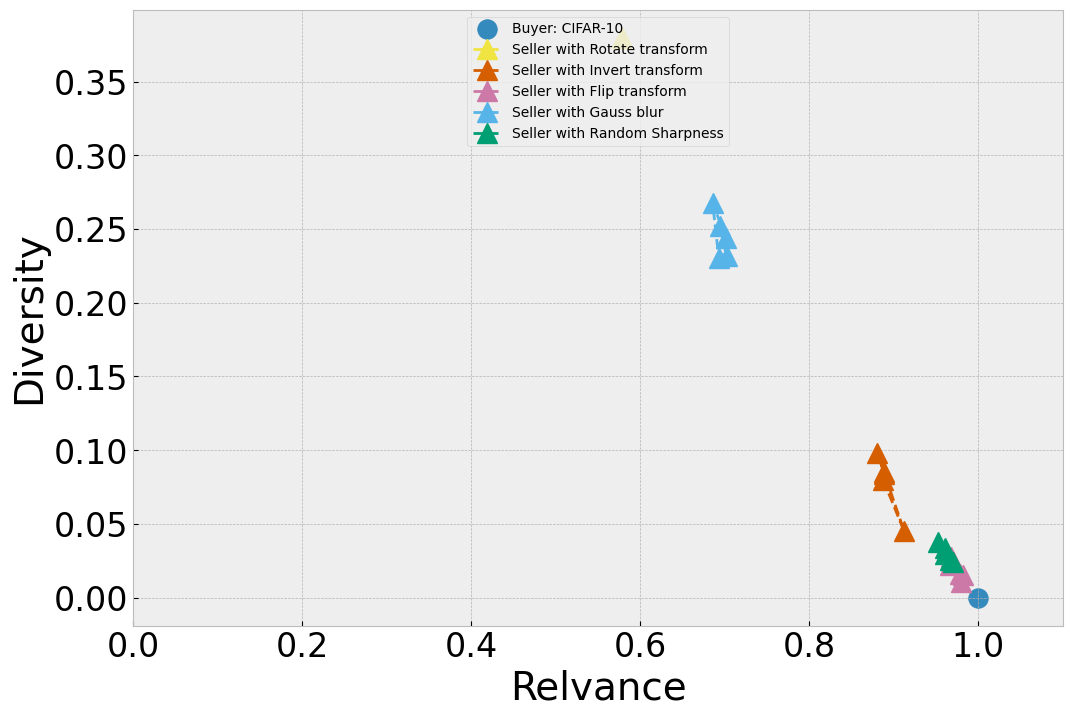

In [ ]:
s = 400
plt.figure(figsize=(12, 8))
plt.scatter(buyer_rel, buyer_div, s=200, marker='o', label='Buyer: CIFAR-10')
# plt.scatter(seller_rel, seller_div, s=200, marker='s', label='Seller: CIFAR-10')
# plt.scatter(shift_rel, shift_div, s=200, marker='D', label='Seller: CIFAR-10.1')
plt.plot(rotate_valuations['relevance'], rotate_valuations['diversity'], '^--', c='C8', markersize=15, label=f'Seller with Rotate transform')
plt.plot(invert_valuations['relevance'], invert_valuations['diversity'], '^--', c='C4', markersize=15, label=f'Seller with Invert transform')
plt.plot(flip_valuations['relevance'], flip_valuations['diversity'], '^--', c='C5', markersize=15, label=f'Seller with Flip transform')
plt.plot(gauss_blur_valuations['relevance'], gauss_blur_valuations['diversity'], '^--', c='C6', markersize=15, label=f'Seller with Gauss blur')
plt.plot(random_sharpness_valuations['relevance'], random_sharpness_valuations['diversity'], '^--', c='C7', markersize=15, label=f'Seller with Random Sharpness')


plt.xlabel('Relvance', fontsize=28)
plt.ylabel('Diversity', fontsize=28)
plt.xlim(0, 1.1)
plt.title(label='',fontsize=20, pad=12)
plt.tick_params(labelsize=24)
plt.legend(loc = 'upper center')

### Experiment on CNN defined in digits.py, tested on transformed image data

In [ ]:
import valuation
import models
import digits
import importlib
importlib.reload(digits)


<module 'digits' from '/content/digits.py'>

In [ ]:
class args():
    def __init__(self, lr, epochs, debug):
        self.learning_rate = lr
        self.epochs = 10
        self.debug = debug


arg = args(5e-5,10,False)
print(buyer_data.shape)
print(rotate_seller_data.shape)

rotate_returns = digits.train(torch.tensor(buyer_data.astype(np.float32)).permute(0,3,1,2).cuda(),
                              buyer_targets, torch.tensor(buyer_data.astype(np.float32)).permute(0,3,1,2).cuda(), buyer_targets, arg)
print(rotate_returns)

rotate_returns = digits.train(torch.tensor(buyer_data.astype(np.float32)).permute(0,3,1,2).cuda(),
                              buyer_targets, torch.tensor(random_sharpness_seller_data.astype(np.float32)).permute(0,3,1,2).cuda(), seller_targets, arg)
print(rotate_returns)

(50000, 32, 32, 3)
(10000, 32, 32, 3)



100%|██████████| 10/10 [00:36<00:00,  3.70s/it]


{'metrics': {'accuracy': 0.10666}, 'losses': {'classification': {0: 3600.729292869568, 1: 3599.331642627716, 2: 3598.009286880493, 3: 3596.744264125824, 4: 3595.519691467285, 5: 3594.314464330673, 6: 3593.101854324341, 7: 3591.9205021858215, 8: 3590.8109180927277, 9: 3589.7474086284637}}}



100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


{'metrics': {'accuracy': 0.1}, 'losses': {'classification': {0: 721.2320272922516, 1: 721.2120394706726, 2: 721.1921553611755, 3: 721.1723325252533, 4: 721.1526470184326, 5: 721.1331040859222, 6: 721.1136374473572, 7: 721.0942788124084, 8: 721.0749852657318, 9: 721.0558004379272}}}


Train a simple model on embeddings (linear or multiclass classifier)
Code skeleton here: https://github.com/openai/CLIP
Experiment on imagenet with larger sized images
Moving forward -> Satellite images, medical images
Control Seller with no transformations, non-CIFAR, identically distributed to buyer dataset

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1, verbose=1)
classifier.fit(features_dict['embed_buyer_data'], buyer_targets[:10000])

# Evaluate using the logistic regression classifier
predictions = classifier.predict(features_dict['sharp_data'])
accuracy = np.mean((seller_targets == predictions).astype(float)) * 100.
print(f"Sharp Accuracy = {accuracy:.3f}")

predictions = classifier.predict(features_dict['gauss_blur'])
accuracy = np.mean((seller_targets == predictions).astype(float)) * 100.
print(f"Gauss Accuracy = {accuracy:.3f}")

predictions = classifier.predict(features_dict['rot_seller_data'])
accuracy = np.mean((seller_targets == predictions).astype(float)) * 100.
print(f"Rotate Accuracy = {accuracy:.3f}")

predictions = classifier.predict(features_dict['inv_seller_data'])
accuracy = np.mean((seller_targets == predictions).astype(float)) * 100.
print(f"Invert Accuracy = {accuracy:.3f}")

predictions = classifier.predict(features_dict['flip_data'])
accuracy = np.mean((seller_targets == predictions).astype(float)) * 100.
print(f"Flip Accuracy = {accuracy:.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[3 8 8 ... 3 3 7]
[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7, 8, 3, 1, 2, 8, 0, 8, 3, 5, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 9, 6, 5, 6, 3, 8, 7, 6, 2, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 5, 4, 2, 1, 6, 6, 8, 4, 8, 4, 5, 0, 9, 9, 9, 8, 9, 9, 3, 7, 5, 0, 0, 5, 2, 2, 3, 8, 6, 3, 4, 0, 5, 8, 0, 1, 7, 2, 8, 8, 7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 4, 5, 9, 8, 0, 7, 9, 8, 2, 7, 6, 9, 4, 3, 9, 6, 4, 7, 6, 5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 1, 8, 9, 0, 3, 1, 9, 2, 2, 5, 3, 9, 9, 4, 0, 3, 0, 0, 9, 8, 1, 5, 7, 0, 8, 2, 4, 7, 0, 2, 3, 6, 3, 8, 5, 0, 3, 4, 3, 9, 0, 6, 1, 0, 9, 1, 0, 7, 9, 1, 2, 6, 9, 3, 4, 6, 0, 0, 6, 6, 6, 3, 2, 6, 1, 8, 2, 1, 6, 8, 6, 8, 0, 4, 0, 7, 7, 5, 5, 3, 5, 2, 3, 4, 1, 7, 

train on seller, predict on buyer


could combine datasets, randomly split

scree plot to find number of components to use in PCA (eigenvalues vs components in pca)


opendataval package - inspect some of their data valuation methods to benchmark our data valuation methods. Attributes model performance to certain data points.

Can they pick out noisy data?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=500, verbose=1)
classifier.fit(features_dict['sharp_data'], seller_targets)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(features_dict['embed_buyer_data'])
accuracy = accuracy_score(buyer_targets[:10000], predictions)
# accuracy = np.mean((buyer_targets == predictions).astype(float)) * 100.
print(f"Sharp Accuracy = {accuracy:.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sharp Accuracy = 0.956


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=500, verbose=1)
classifier.fit(features_dict['gauss_blur'], seller_targets)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(features_dict['embed_buyer_data'])
accuracy = accuracy_score(buyer_targets[:10000], predictions)
# accuracy = np.mean((buyer_targets == predictions).astype(float)) * 100.
print(f"Gauss Accuracy = {accuracy:.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Gauss Accuracy = 0.950


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=500, verbose=1)
classifier.fit(features_dict['rot_seller_data'], seller_targets)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(features_dict['embed_buyer_data'])
accuracy = accuracy_score(buyer_targets[:10000], predictions)
# accuracy = np.mean((buyer_targets == predictions).astype(float)) * 100.
print(f"Rotate Accuracy = {accuracy:.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Rotate Accuracy = 0.943


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=500, verbose=1)
classifier.fit(features_dict['flip_data'], seller_targets)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(features_dict['embed_buyer_data'])
accuracy = accuracy_score(buyer_targets[:10000], predictions)
# accuracy = np.mean((buyer_targets == predictions).astype(float)) * 100.
print(f"Flip Accuracy = {accuracy:.3f}")

Flip Accuracy = 0.955


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=500, verbose=1)
classifier.fit(features_dict['inv_seller_data'], seller_targets)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(features_dict['embed_buyer_data'])
accuracy = accuracy_score(buyer_targets[:10000], predictions)
# accuracy = np.mean((buyer_targets == predictions).astype(float)) * 100.
print(f"Invert Accuracy = {accuracy:.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Invert Accuracy = 0.951


In [ ]:
import opendataval.dataval as dataval
import opendataval.dataval.api
from opendataval.dataval.ame import AME
from opendataval.dataloader import DataFetcher
from opendataval.experiment import ExperimentMediator
import opendataval.model

In [ ]:
import sklearn
x_train,x_test,y_train,y_test = sklearn.model_selection.train_test_split(features_dict['inv_seller_data'],seller_targets,test_size = .33)
buyer_targets = torch.tensor(np.array(buyer_targets[:10000]).reshape((10000,1)))
y_train = torch.tensor(np.array(y_train).reshape((len(y_train),1)))
y_test = torch.tensor(np.array(y_test).reshape((len(y_test),1)))
x_train = torch.tensor(x_train)
x_test = torch.tensor(x_test)

fetcher = DataFetcher.from_data_splits(x_train,y_train,x_test,y_test,features_dict['embed_buyer_data'],buyer_targets[:10000],one_hot=False)
dataval = (
    AME(num_models=5)
    #use classifier wrapper
    .train(fetcher=fetcher,pred_model=opendataval.model.RegressionSkLearnWrapper(sklearn.linear_model.LogisticRegression),metric=opendataval.metrics.accuracy)
)
data_values = dataval.data_values  # Cached values
data_values = dataval.evaluate_data_values()  # Recomputed values

expermed = ExperimentMediator(fetcher,opendataval.model.RegressionSkLearnWrapper(sklearn.linear_model.LogisticRegression))

expermed.compute_data_values(data_evaluators=[ChildEvaluator()])

In [ ]:
print(len(data_values))

6700


Instead of plotting diversity, use volume metric (consider it as diversity)
Try out different datasets (medmnist) to test how models/results generalize
- repeat exact same thing done w cifar but now w mnist (dataset matching, chest/pneumonia have overlap, but chest and oct/derma have very little)

normal vs abnormal chestmnist